
👉🏻**Task 1:** Introduction and Overview of the project. <br/><br/>
👉🏻**Task 2:** Import Libraries and Download the Dataset. <br/><br/>
👉🏻**Task 3:** Preprocess Data and View Segmentation Mask. <br/><br/>
👉🏻**Task 4:** Define the model. <br/><br/>
👉🏻**Task 5:** Train the model and Visualize Results. <br/><br/>
👉🏻**Task 6:** Make Visualized predictions. <br/><br/>

## 👉🏻Task 1: Introduction and Overview of the Project
In this guided project, we will:
   - Define Image segmentation
   - Define and train the model
   - Make predictions!
   
Image segmentation is a critical process in computer vision. It involves dividing a visual input into segments to simplify image analysis. Segments represent objects or parts of objects, and comprise sets of pixels, or “super-pixels”. Image segmentation sorts pixels into larger components, eliminating the need to consider individual pixels as units of observation.

At the end of this project, you will try out an amazing Bonus Exercise about Neural Networks! 😎

## 👉🏻Task 2: Import Libraries and Download the Dataset




### ⭐ Import Needed Libraries

In [1]:
!pip install -q git+https://github.com/tensorflow/examples.git

In [2]:
!pip install -q -U tfds-nightly

     |████████████████████████████████| 3.7MB 10.1MB/s 


In [3]:
import tensorflow as tf

In [4]:
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
from IPython.display import clear_output
import matplotlib.pyplot as plt 


### ⭐ Download the Oxford-IIIT Pets dataset

So far you have seen image classification 👀, where the task of the network is to assign a label or class to an input image.<br/>
However, suppose you want to know the location of an object in the image, the shape of that object, which pixel belongs to which object, etc. <br/>
In this case you will want to segment the image, i.e., each pixel of the image is given a label. Thus, the task of image segmentation is to train a neural network to output a pixel-wise mask of the image. This helps in understanding the image at a much lower level, i.e., the pixel level. Image segmentation has many applications in medical imaging, self-driving cars and satellite imaging to name a few. 🤩

We will focus on the task of image segmentation, using a modified U-Net -a convolutional network architecture for fast and precise segmentation of images-!  <br/>
<br/>
**Overview of the data set:** <br/>
The dataset that will be used for this poject is the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/), created by Parkhi *et al*. The dataset consists of images, their corresponding labels, and pixel-wise masks. The masks are basically labels for each pixel. Each pixel is given one of three categories :

*   Class 1 : Pixel belonging to the pet.
*   Class 2 : Pixel bordering the pet.
*   Class 3 : None of the above/ Surrounding pixel.

The dataset is already included in TensorFlow datasets, all that is needed to do is download it ⏬.<br/>
(The segmentation masks are included in version 3+)

In [5]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteQR6CGL/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteQR6CGL/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


## 👉🏻Task 3: Preprocess Data and View Segmentation Mask

### ⭐ Preprocess the Data

The following code performs a simple augmentation of flipping an image 🖼. <br/>
➕ In addition, image is normalized to [0,1].<br/>
🏁 Finally, as mentioned above the pixels in the segmentation mask are labeled either {1, 2, 3}. For the sake of convenience, let's subtract 1 from the segmentation mask, resulting in labels that are : {0, 1, 2}.

In [6]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, dtype=float) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [7]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint["image"], (128,128))
  input_mask = tf.image.resize(datapoint["segmentation_mask"], (128,128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image=input_image, input_mask=input_mask)

  return input_image, input_mask
  

In [8]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint["image"], (128, 128))
  input_mask = tf.image.resize(datapoint["segmentation_mask"], (128,128))

  input_image, input_mask = normalize(input_image=input_image, input_mask=input_mask)

  return input_image, input_mask

The dataset already contains the required splits of test and train, so let's continue to use the same split. ✌🏻

In [35]:
TRAIN_LENGTH = info.splits["train"].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEP_PER_EPOCH = TRAIN_LENGTH//BATCH_SIZE

In [10]:
train = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset["test"].map(load_image_test)

In [11]:

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

### ⭐ Segmentation Map

Let's take a look at an image example and it's correponding mask from the dataset. 🏃🏻‍♂️

In [12]:
def display(display_list):
  plt.figure(figsize=(15,15))

  title = ["Input Image", "True Mask", "Predicted Mask"]

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis("off")
  plt.show()

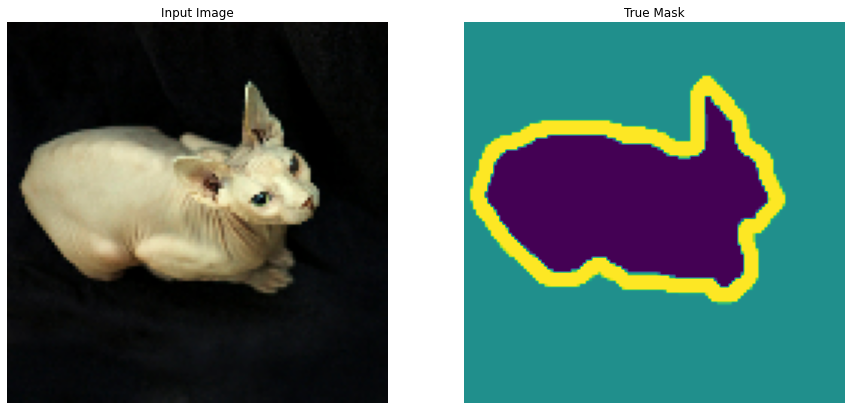

In [13]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

## 👉🏻Task 4: Define the model
The model being used here is a modified U-Net.<br/>
⚠ A U-Net consists of an encoder (downsampler) and decoder (upsampler). In-order to learn robust features, and reduce the number of trainable parameters, a pretrained model can be used as the encoder. Thus, the encoder for this task will be a pretrained MobileNetV2 model, whose intermediate outputs will be used.<br/> 

⚠ The reason to output three channels is because there are three possible labels for each pixel.

In [15]:
OutPUT_CHANNELS = 3

👆🏻 As mentioned, the encoder will be a pretrained MobileNetV2 model which is prepared and ready to use in [tf.keras.applications](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications). The encoder consists of specific outputs from intermediate layers in the model.<br/>
📝 Note that the encoder will not be trained during the training process.

In [18]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128,128,3], include_top=False)

# Use the activations of these layers
layer_names = [
               'block_1_expand_relu',   # 64x64
               'block_3_expand_relu',   # 32x32
               'block_6_expand_relu',   # 16x16
               'block_13_expand_relu',  # 8x8
               'block_16_project'       # 4x4
]

layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples. <br/>
( the decoder has these "Upsample" layers that you might not have seen before 👀)

In [19]:
up_stack = [
            pix2pix.upsample(512, 3), # 4x4 -> 8x8
            pix2pix.upsample(256, 3), # 8x8 -> 16x16
            pix2pix.upsample(128, 3), # 16x16 -> 32x32
            pix2pix.upsample(64, 3)   # 32x32 -> 64x64
]

In [20]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128,128,3])
  x=inputs

  # Downsampling through the model
  skips = down_stack(x)
  x=skips[-1]
  skips=reversed(skips[:-1])

  # Upsamling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # this is last layer of model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 
      3, 
      strides=2,
      padding='same')
  
  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

## 👉🏻Task 5: Train the model and Visualize Results
Now, all that is left to do is to compile and train the model 🔧🔩.<br/>
The loss being used here is `losses.SparseCategoricalCrossentropy(from_logits=True)`.<br/>
The reason to use this loss function is because the network is trying to assign each pixel a label, just like multi-class prediction. In the true segmentation mask, each pixel has either a {0,1,2}.<br/>
🕸 The network here is outputting three channels 3️⃣.<br/> 
Essentially, each channel is trying to learn to predict a class, and `losses.SparseCategoricalCrossentropy(from_logits=True)` is the recommended loss for 
such a scenario. Using the output of the network, the label assigned to the pixel is the channel with the highest value. This is what the create_mask function is doing.

In [23]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

A quick look at the resulting model architecture: 👀🏃🏻‍♀️

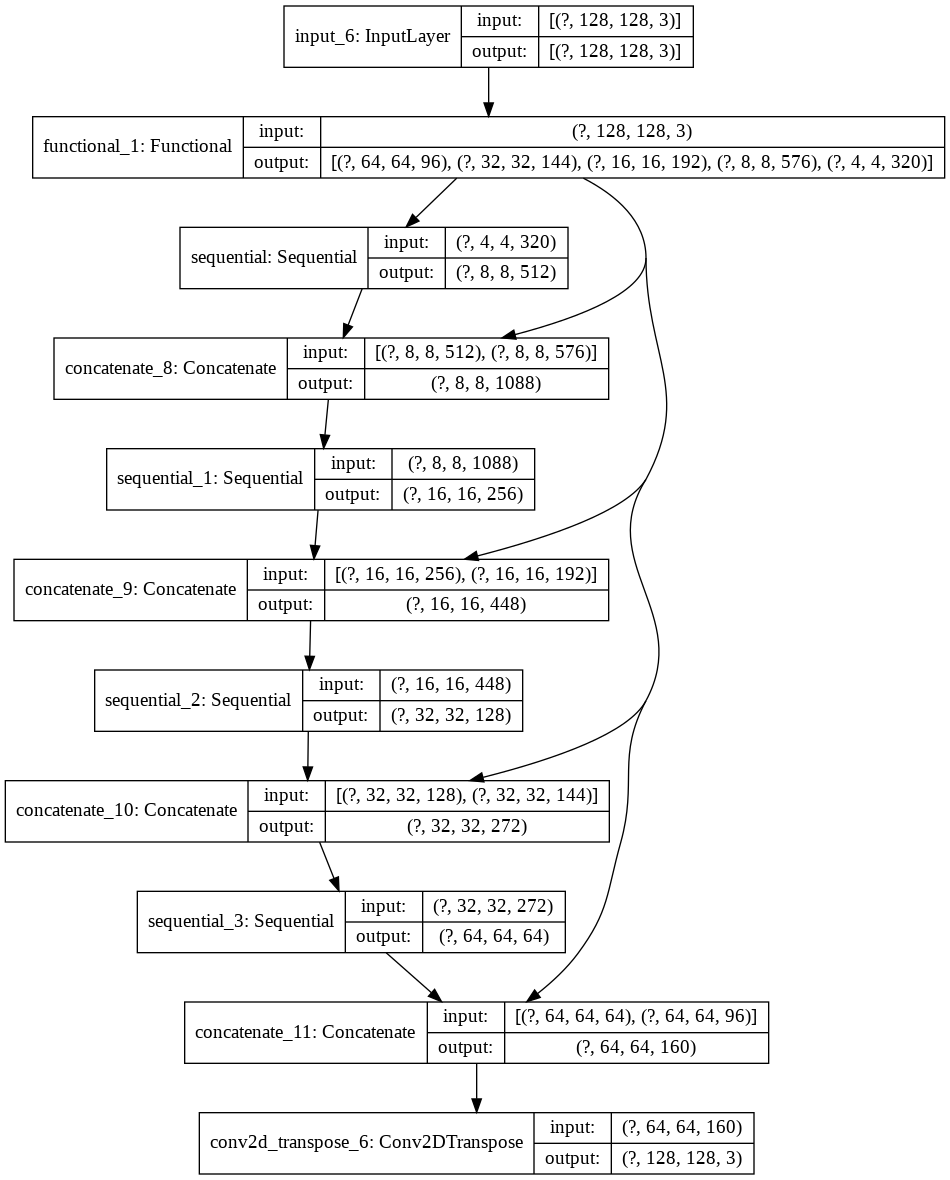

In [24]:
tf.keras.utils.plot_model(model, show_shapes=True)

Let us try out the model to see what it predicts before training. 👀🤔

In [31]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [32]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], 
               mask[0], 
               create_mask(pred_mask)])
  else:
    display([sample_image, 
             sample_mask, 
             create_mask(model.predict(sample_image[tf.newaxis,...]))])

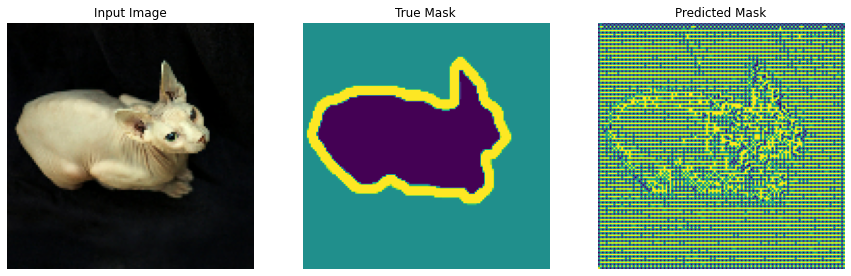

In [33]:
show_predictions()

Let us observe how the model improves while it is training. 👀

In [39]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, longs=None):
    clear_output(wait=True)
    show_predictions()
    print("\nSamole Predictions after epoch {}\n".format(epoch+1))


 To accomplish this task, a callback function is defined. 👆🏻 

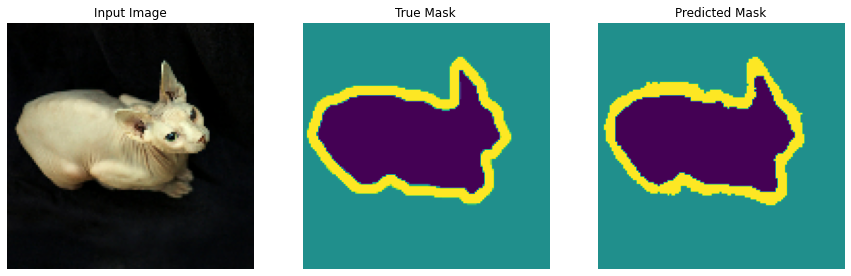


Samole Predictions after epoch 25

57/57 [==============================] - 6s 104ms/step - loss: 0.1016 - accuracy: 0.9519 - val_loss: 0.3771 - val_accuracy: 0.8891


In [40]:
EPOCHS = 25
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits["test"].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset,
                          epochs=EPOCHS,
                          steps_per_epoch=STEP_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

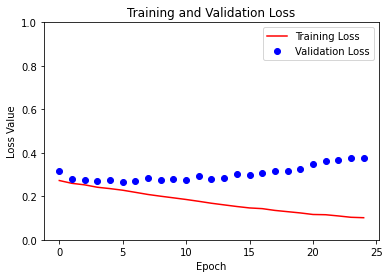

In [42]:
loss = model.history.history["loss"]
val_loss = model.history.history["val_loss"]

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, "bo", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.ylim([0, 1])
plt.legend()
plt.show()

## 👉🏻Task 6: Make Visualized predictions

Let's make some predictions. 🔮 <br/>
In the interest of saving time ⏳, the number of epochs was kept small, but you may set this higher to achieve more accurate results.

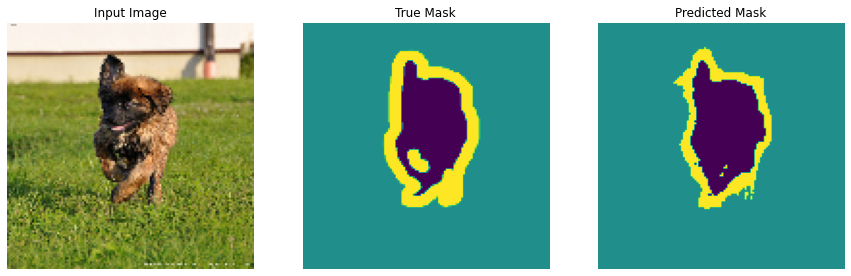

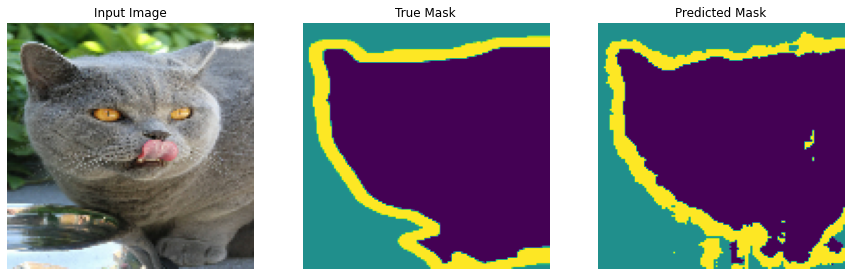

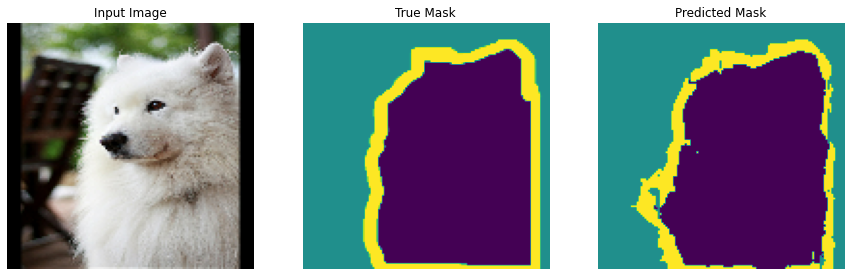

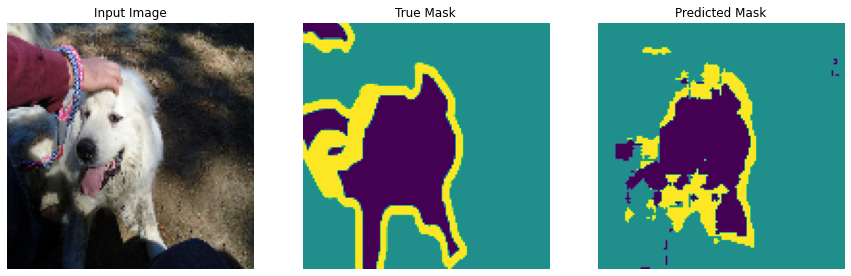

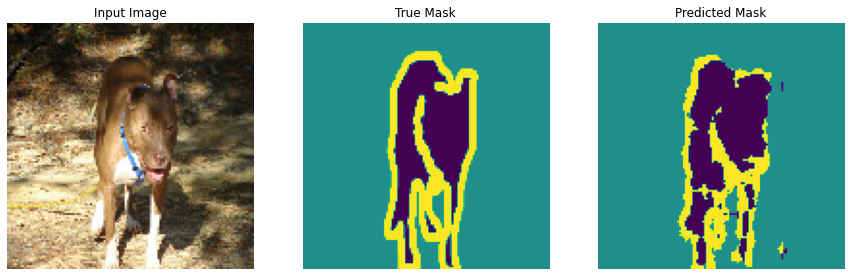

In [43]:
show_predictions(test_dataset, 5)


To train a neural network model to classify images of clothing, like sneakers and shirts... You should import a data set of these objects, but you have a popular dataset from tensorflow data sets 🤔.<br/>
So what is this data set? 🤔 and how to import it?? 🤗
<br/>

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

Each image is mapped to a single label. Since the class names are not included with the dataset, store them here to use later when plotting the images:

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the training set and the testing set be preprocessed in the same way
<br/> . <br/> 

In [ ]:
train_images = train_images / 255.0

test_images = test_images / 255.0

let's display the first 25 images from the training set and display the class name below each image.👁👁
<br/> . 

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()